In [31]:
print('Hello AlgoSoc!')


Hello AlgoSoc!


# Writing Trading Alogrithms

# Plan For Today
1. Import Data
2. Compute Signal
3. Backtest
4. Optimization

Note: you may need to restart the kernel to use updated packages.


In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import plotly.express as px


In [128]:
# Ticker list to download
tickers = 'SPY QQQ TLT AAPL MSFT GOOG AMZN NFLX NVDA ADBE'

# Download data from Yahoo-Finance
data = yf.download(
    tickers = tickers, 
    period = 'max',
    interval = "1d", 
    ignore_tz=True,
    auto_adjust=True, # Adjust all fields by splits and dividends
    #group_by='ticker',
)

# get close adjusted prices
data = data['Close']
data["20050101":].head()
data = data["20050101":]

[*********************100%%**********************]  10 of 10 completed


In [129]:
ticker = 'SPY'
close_adj = data[[ticker]].copy()
close_adj.columns = ['close']
close_adj.head()

,close
Date,
2005-01-03,83.962433
2005-01-04,82.936455
2005-01-05,82.364136
2005-01-06,82.782898
2005-01-07,82.664253


In [130]:
close_adj['R'] = close_adj.close.pct_change().fillna(0)
close_adj.head()

,close,R
Date,,
2005-01-03,83.962433,0.000000
2005-01-04,82.936455,-0.012219
2005-01-05,82.364136,-0.006901
2005-01-06,82.782898,0.005084
2005-01-07,82.664253,-0.001433


In [131]:
close_adj["slow_ma"] = close_adj.close.rolling(window = 50).mean()
close_adj["fast_ma"] = close_adj.close.rolling(window = 10).mean()

<Axes: xlabel='Date'>

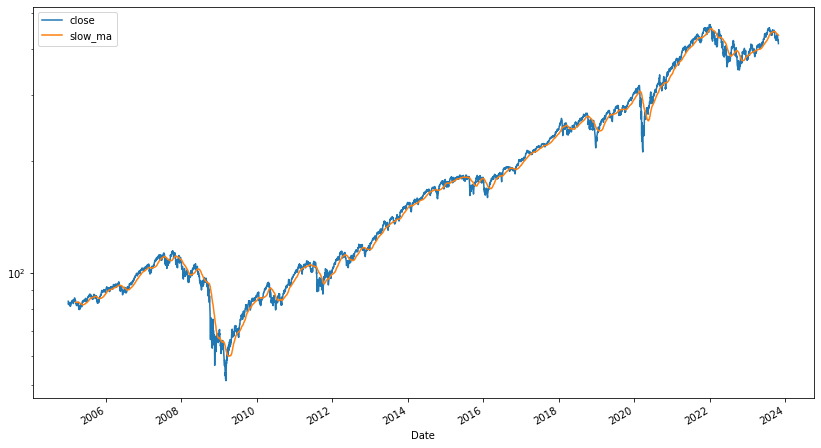

In [132]:
close_adj[['close','slow_ma']].plot(logy=True, figsize = (14,8))

<Axes: xlabel='Date'>

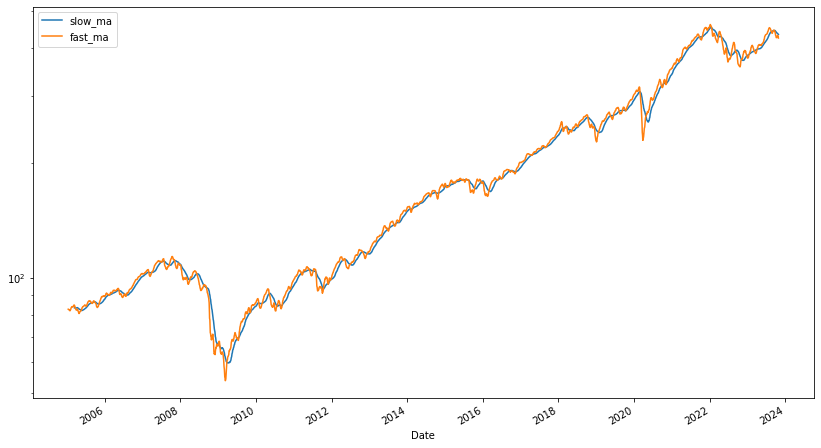

In [133]:
close_adj[['slow_ma','fast_ma']].plot(logy=True, figsize = (14,8))

<Axes: xlabel='Date'>

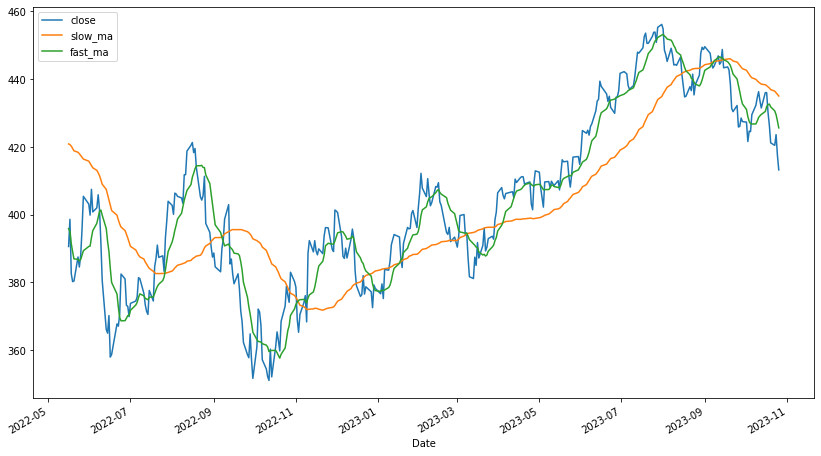

In [134]:
close_adj[['close','slow_ma', 'fast_ma']].tail(365).plot(figsize = (14,8))

# 2. Compute Signals

In [136]:
close_adj.tail(3)

,close,R,slow_ma,fast_ma
Date,,,,
2023-10-24,423.630005,0.007539,436.003280,429.545999
2023-10-25,417.549988,-0.014352,435.527614,427.668997
2023-10-26,413.209991,-0.010394,435.029920,425.623996


In [138]:
close_adj.head(3)

,close,R,slow_ma,fast_ma
Date,,,,
2005-01-03,83.962433,0.000000,NaN,NaN
2005-01-04,82.936455,-0.012219,NaN,NaN
2005-01-05,82.364136,-0.006901,NaN,NaN


In [139]:
close_adj = close_adj[~close_adj.slow_ma.isnull()]
close_adj.head()

,close,R,slow_ma,fast_ma
Date,,,,
2005-03-15,83.850746,-0.008255,83.449572,84.738532
2005-03-16,83.138847,-0.008490,83.433100,84.595456
2005-03-17,83.306358,0.002015,83.440498,84.465639
2005-03-18,83.059013,-0.002969,83.454396,84.205696
2005-03-21,82.750717,-0.003712,83.453752,83.910736


In [141]:
close_adj = close_adj.assign(
    signal = lambda x: np.where(x.fast_ma > x.slow_ma, 1, 0)
)

In [142]:
close_adj

,close,R,slow_ma,fast_ma,signal
Date,,,,,
2005-03-15,83.850746,-0.008255,83.449572,84.738532,1
2005-03-16,83.138847,-0.008490,83.433100,84.595456,1
2005-03-17,83.306358,0.002015,83.440498,84.465639,1
2005-03-18,83.059013,-0.002969,83.454396,84.205696,1
2005-03-21,82.750717,-0.003712,83.453752,83.910736,1
...,...,...,...,...,...
2023-10-20,421.190002,-0.012288,436.933849,431.820001,0
2023-10-23,420.459991,-0.001733,436.461378,430.637000,0
2023-10-24,423.630005,0.007539,436.003280,429.545999,0


In [144]:
close_adj['signal'] = close_adj['signal'].shift(1,fill_value = 0)

In [145]:
close_adj['R_strategy'] = close_adj.R * close_adj.signal
close_adj.head()


,close,R,slow_ma,fast_ma,signal,R_strategy
Date,,,,,,
2005-03-15,83.850746,-0.008255,83.449572,84.738532,0,-0.000000
2005-03-16,83.138847,-0.008490,83.433100,84.595456,0,-0.000000
2005-03-17,83.306358,0.002015,83.440498,84.465639,1,0.002015
2005-03-18,83.059013,-0.002969,83.454396,84.205696,1,-0.002969
2005-03-21,82.750717,-0.003712,83.453752,83.910736,1,-0.003712


# Backtest

In [147]:
# Build a function to pass in any ticker

def get_signal(data, ticker, fast_ma, slow_ma):

    close_adj = data[[ticker]].copy()
    close_adj.columns = ['close']

    # Compute Returns
    close_adj['R'] = close_adj.close.pct_change().fillna(0)
    
    # Define inidcators - Change to EMA
    close_adj['fast_ma'] = close_adj.close.ewm(span = fast_ma, min_periods= fast_ma).mean()
    close_adj['slow_ma'] = close_adj.close.ewm(span = slow_ma, min_periods= slow_ma).mean()
   
    close_adj = close_adj[~close_adj.slow_ma.isnull()]

    close_adj = close_adj.assign(
        signal = lambda x: np.where(x.fast_ma > x.slow_ma,1,0)
    )

    # Lag the signal
    close_adj['signal'] = close_adj['signal'].shift(1,fill_value = 0)
    close_adj['R_strategy'] = close_adj.R * close_adj.signal

    return close_adj


In [148]:
ticker = 'SPY'
df_signal = get_signal(data,ticker, fast_ma=10, slow_ma=65)
df_signal.head()

,close,R,fast_ma,slow_ma,signal,R_strategy
Date,,,,,,
2005-04-06,83.101028,0.003469,82.680898,83.263560,0,0.0
2005-04-07,83.549461,0.005396,82.838819,83.273532,0,0.0
2005-04-08,82.680649,-0.010399,82.810061,83.252947,0,-0.0
2005-04-11,82.743690,0.000762,82.797994,83.235343,0,0.0
2005-04-12,83.171127,0.005166,82.865836,83.233132,0,0.0


In [150]:
# Total Return
100 * (1+ df_signal[['R','R_strategy']]).prod() -1

R             497.962879
R_strategy    465.546051
dtype: float64

In [151]:
px.line(100 * (1 + df_signal [['R', 'R_strategy']]).cumprod(), title = 'Total Return')

In [153]:
def performance(df_strategy, ticker, freq = 'M', risk_free_rate = 0.02):

    rets = df_strategy[['R', 'R_strategy']].copy()
    rets.columns = ['Buy & Hold', 'Strategy']

    if freq == 'D':
        scale = 252
    elif freq == 'M':    
        scale = 12
        rets = rets.resample(freq).agg(lambda x: (1 + x).prod() - 1)
    else:
        return None

    #  Compute Results
    ret_cumulative = (1 + rets).cumprod()
    previous_peaks = ret_cumulative.cummax()
    drawdown = (ret_cumulative - previous_peaks) / previous_peaks

    #Compute Annualized Returns and risk
    annualized_returns = (1 + rets.mean())** scale -1 
    annualized_std_deviation = rets.std() * np.sqrt(scale)
    max_drawdown = drawdown.min() -1 

    df_risk_return = pd.DataFrame(
        dict(
            ticker = ticker,
            annualized_returns = annualized_returns,
            annualized_std_deviation = annualized_std_deviation,
        )
    )

    df_risk_return['Max Drawdown'] = drawdown.min() * -1  # Max Drawdown == Largest drop in returns
    df_risk_return = df_risk_return.assign()

    return df_risk_return



In [154]:
performance(df_signal ,ticker, freq = 'D', risk_free_rate=0.05)

,ticker,annualized_returns,annualized_std_deviation,Max Drawdown
Buy & Hold,SPY,0.111428,0.194683,0.551894
Strategy,SPY,0.093630,0.113409,0.182673


# Optimizing Algo

In [155]:
results = []
for fast_ma in range(5, 50,5):
    for slow_ma in range(30, 300, 5):
        if fast_ma >= slow_ma:
            continue
        else:
            # compute signal
            df_signal = get_signal(data, ticker, fast_ma, slow_ma)

            # compute performance
            perf = performance(df_signal, ticker, freq = 'D', risk_free_rate= 0.02)

            perf['fast_ma'] = fast_ma
            perf['slow_ma'] = slow_ma
            results.append( perf.tail(1) )

In [156]:
df_res  = pd.concat(results)
df_res

,ticker,annualized_returns,annualized_std_deviation,Max Drawdown,fast_ma,slow_ma
Strategy,SPY,0.060035,0.110986,0.349085,5,30
Strategy,SPY,0.053442,0.108676,0.312771,5,35
Strategy,SPY,0.054039,0.109500,0.269852,5,40
Strategy,SPY,0.068845,0.109113,0.236786,5,45
Strategy,SPY,0.066474,0.109484,0.193105,5,50
...,...,...,...,...,...,...
Strategy,SPY,0.062031,0.141531,0.343266,45,275
Strategy,SPY,0.060195,0.141803,0.360057,45,280
Strategy,SPY,0.058790,0.142369,0.361738,45,285
Strategy,SPY,0.056312,0.142984,0.361738,45,290


In [157]:
df_res.sort_values('annualized_returns', ascending=False).head()

,ticker,annualized_returns,annualized_std_deviation,Max Drawdown,fast_ma,slow_ma
Strategy,SPY,0.093630,0.113409,0.182673,10,65
Strategy,SPY,0.091730,0.113402,0.192862,10,70
Strategy,SPY,0.090634,0.116970,0.210713,35,55
Strategy,SPY,0.090578,0.117445,0.224081,30,60
Strategy,SPY,0.088979,0.115195,0.226140,30,40


In [158]:
eval_metric = 'annualized_returns'

df_mat = df_res.pivot(index = 'fast_ma', columns = 'slow_ma', values=eval_metric)

fig = px.imshow(df_mat,
                color_continuous_scale = 'RdYlGn',
                aspect = 'auto')

fig.update_layout(
    title=eval_metric,
    xaxis_title='Slow MA',
    yaxis_title='Fast MA',
    
)

fig

# Time To Code!

# Mean Reversion -  (Pairs Trading)
- Long Pair: Long stock A and short stock B
- Short Pair: Short stock A and long stock B
- You want to find a high correlation between stock A and B's price (usually > 0.8) --  in this case let's say 0.9. If you find a relationship suggesting that the prices move in opposite directions, you can capitalize on this behavior. ONCE the assets deviate from their typical correlation, say 0.5, you can long/short the pair since you expect the correlation to converge back to its original form.
- Sort of becomes an art when you try to maximize the spread between the assets

# Basic Idea
- 1) Find 2 assets that move similarly with eachother (whether it be a negative or positive correlation)
- 2) Sell the 'overvalued' stock and buy the 'undervalued' stock
-- A common signal to use to triger the purchase of a pair trade is to use the Price Ratio (Stock A / Stock B). If the ratio changes significantly, then you know it is time to trade. 'Significance' can be measured with standard deviation , i.e. when the price ratio of the 2 exceeds a certain number of standard deviations from the mean you create a buy or sell signal based on which direction the price ratio is.

In [159]:
# Getting Data from 6 years back
# I will use the most recent 1 year to determine how well I would have done if I follow the efficient frontier.
# The market is open 252 times in a given year.
# I will get the adjusted close as my main data.

import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import plotly.express as px
# Ticker list to download
tickers = ["DPZ", "AAPL", "GOOG", "AMD", "GME", "SPY", "NFLX", "BA", "WMT","GS","XOM","NKE","BRK-B", "MSFT"] #Name of company (Dominos pizza)





# Download data from Yahoo-Finance
data = yf.download(
    tickers = tickers, 
    period = '5y',
    interval = "1d", 
    ignore_tz=True,
    auto_adjust=True, # Adjust all fields by splits and dividends
    #group_by='ticker',
)

# get close adjusted prices
d = data['Close']
d


[*********************100%%**********************]  14 of 14 completed


,AAPL,AMD,BA,BRK-B,DPZ,GME,GOOG,GS,MSFT,NFLX,NKE,SPY,WMT,XOM
Date,,,,,,,,,,,,,,
2018-10-26,51.789459,17.629999,347.496826,198.490005,248.075653,3.222942,53.573502,189.344604,101.337273,299.829987,68.511002,244.085190,90.890999,59.974182
2018-10-29,50.817352,16.850000,324.592804,200.039993,243.565033,3.415707,51.004002,191.243759,98.390770,284.839996,68.625084,242.732910,91.681023,59.602867
2018-10-30,51.071152,17.200001,338.443573,203.350006,252.814240,3.448618,51.810501,195.514618,98.277077,285.809998,70.830498,246.329803,94.087875,60.941132
2018-10-31,52.402397,18.209999,343.231354,205.279999,255.245239,3.432163,53.838501,200.944626,101.195160,301.779999,71.334328,248.960815,92.121986,61.637341
2018-11-01,53.206898,20.219999,351.172333,205.860001,252.643280,3.608473,53.500000,202.371201,100.351952,317.380005,72.997917,251.610184,92.397568,62.403160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-20,172.880005,101.809998,180.039993,335.859985,347.690002,13.440000,136.740005,300.049988,326.670013,400.959991,102.669998,421.190002,158.759995,111.080002
2023-10-23,173.000000,100.010002,181.029999,336.839996,348.299988,13.440000,137.899994,299.220001,329.320007,406.839996,102.809998,420.459991,161.009995,109.449997
2023-10-24,173.440002,101.669998,182.360001,338.630005,353.589996,14.040000,140.119995,299.179993,330.529999,413.730011,105.180000,423.630005,163.250000,108.389999


In [160]:
corr_matrix = d.corr()
corr_matrix

,AAPL,AMD,BA,BRK-B,DPZ,GME,GOOG,GS,MSFT,NFLX,NKE,SPY,WMT,XOM
AAPL,1.000000,0.915271,-0.686401,0.888857,0.690642,0.672764,0.904617,0.863580,0.974702,0.229496,0.681282,0.957489,0.919107,0.565531
AMD,0.915271,1.000000,-0.626874,0.746111,0.824040,0.679893,0.920416,0.800836,0.946052,0.484809,0.822612,0.923990,0.840237,0.295107
BA,-0.686401,-0.626874,1.000000,-0.418924,-0.598297,-0.384230,-0.526477,-0.440527,-0.644185,-0.116561,-0.404754,-0.537670,-0.657991,-0.187841
BRK-B,0.888857,0.746111,-0.418924,1.000000,0.465081,0.641756,0.840483,0.868007,0.870078,-0.004964,0.503939,0.901669,0.804271,0.788176
DPZ,0.690642,0.824040,-0.598297,0.465081,1.000000,0.698658,0.804932,0.688467,0.748350,0.645559,0.850054,0.751444,0.646382,-0.047654
GME,0.672764,0.679893,-0.384230,0.641756,0.698658,1.000000,0.824596,0.848250,0.711006,0.327773,0.735628,0.785199,0.541178,0.273485
GOOG,0.904617,0.920416,-0.526477,0.840483,0.804932,0.824596,1.000000,0.904266,0.948189,0.387746,0.793613,0.966109,0.804173,0.407257
GS,0.863580,0.800836,-0.440527,0.868007,0.688467,0.848250,0.904266,1.000000,0.873240,0.263032,0.756798,0.943487,0.769628,0.568702
MSFT,0.974702,0.946052,-0.644185,0.870078,0.748350,0.711006,0.948189,0.873240,1.000000,0.336630,0.723418,0.970403,0.906502,0.506200
NFLX,0.229496,0.484809,-0.116561,-0.004964,0.645559,0.327773,0.387746,0.263032,0.336630,1.000000,0.652888,0.334891,0.321332,-0.454094


<Axes: >

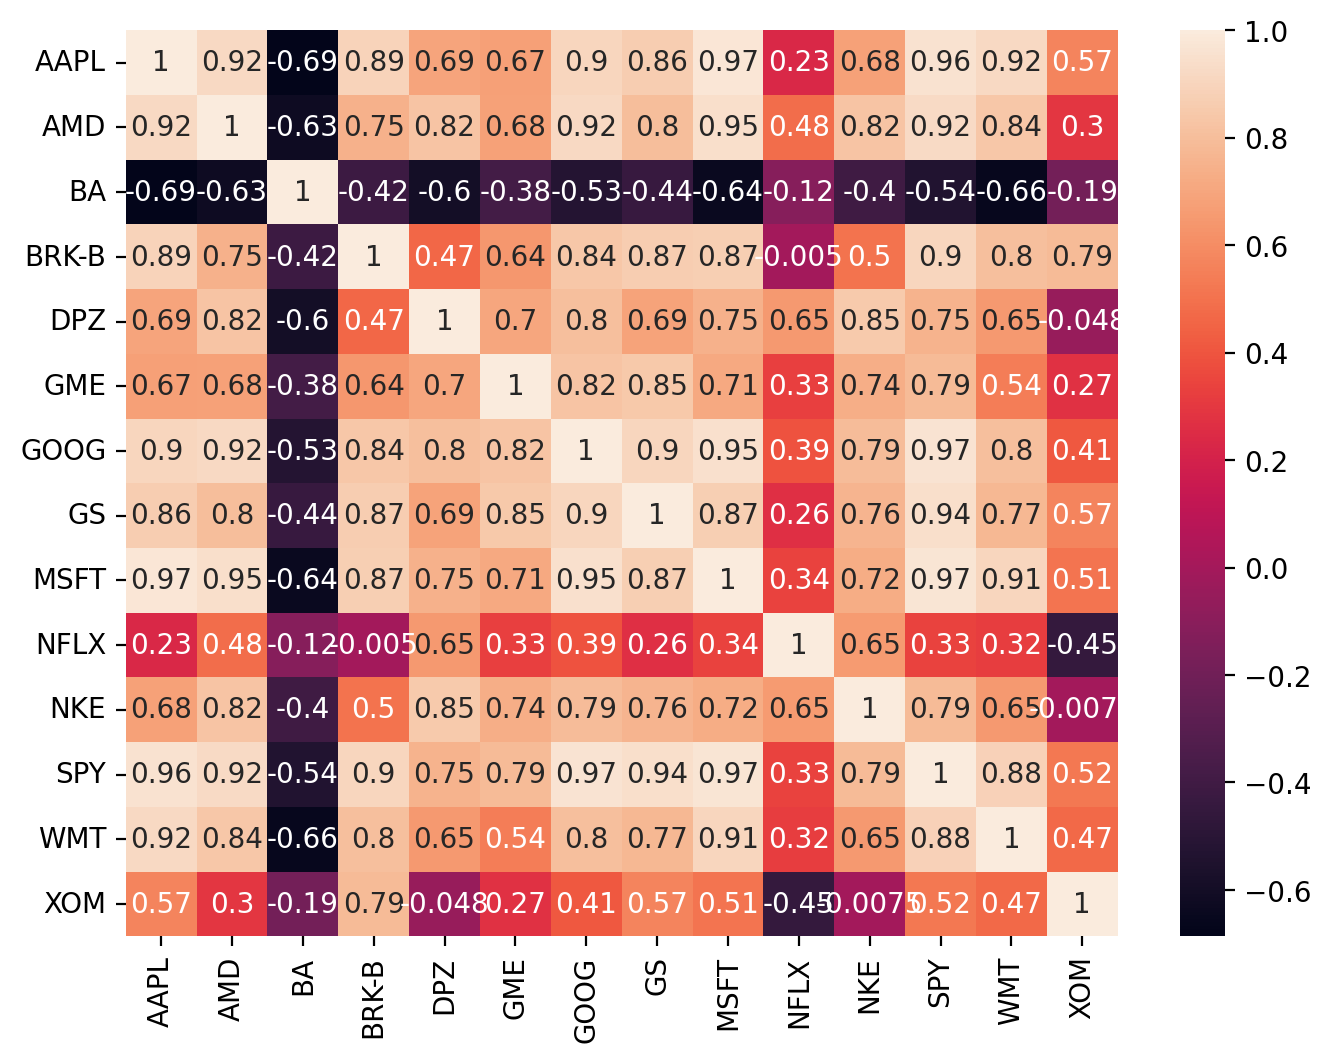

In [161]:
# Let's heatmap this matrix so that we can have a better sense of what is going on
import seaborn as sn
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=200)
sn.heatmap(corr_matrix, annot = True)

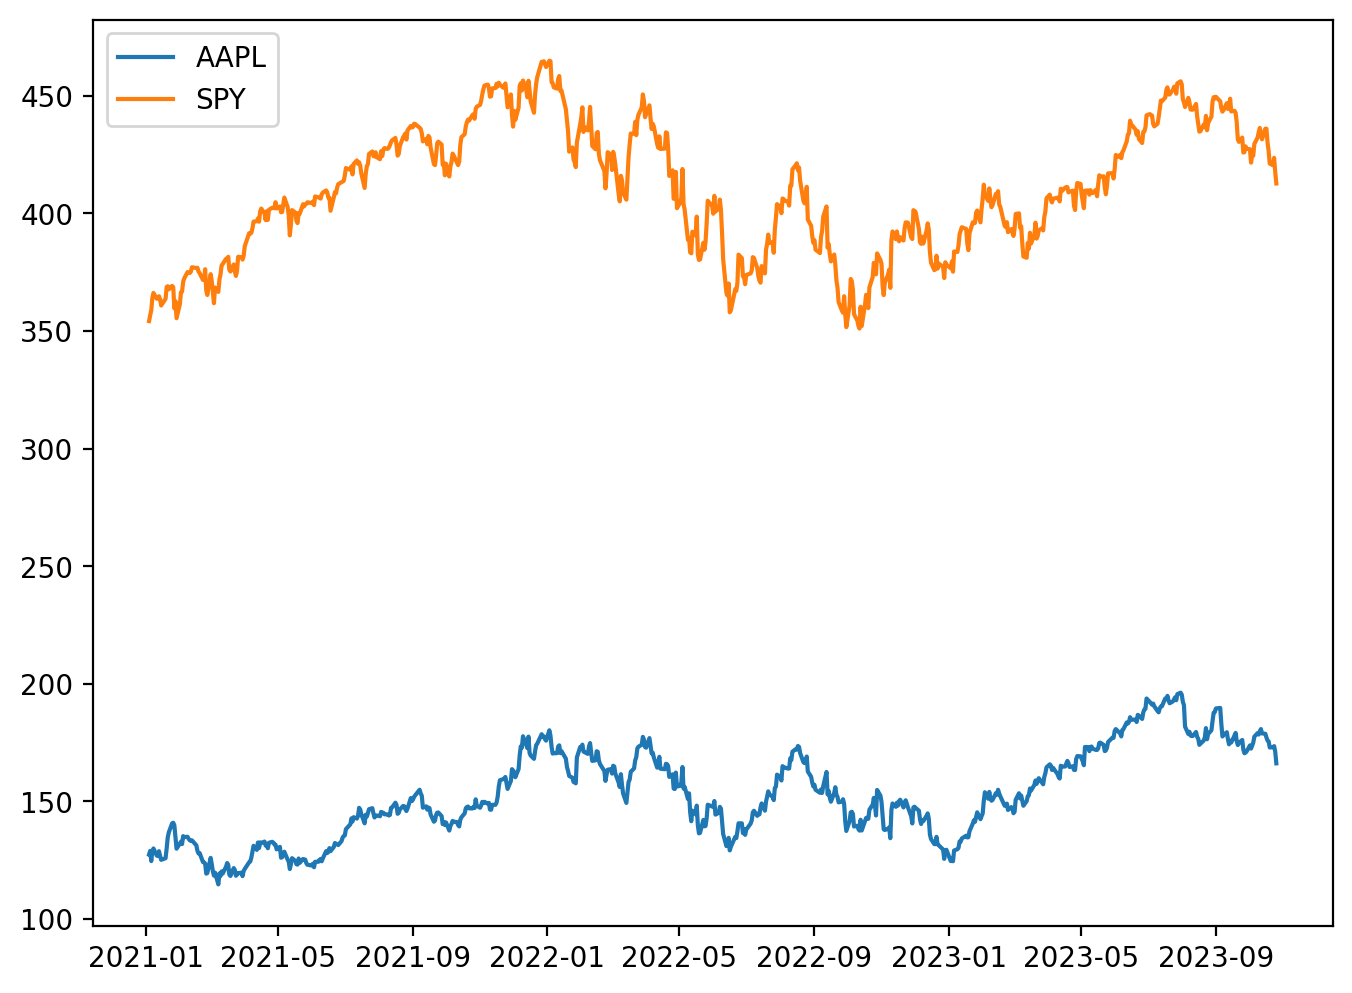

In [162]:
ticker_A = 'AAPL' # Insert column name of ticker you want to plot i.e. Apple = 'AAPL'
ticker_B = 'SPY'

Stock_A = d[ticker_A]['2021-01-01':] 
Stock_B = d[ticker_B]['2021-01-01':]  # Stock B

import matplotlib.pyplot as plt
figure(figsize=(8, 6), dpi=200)

# Plot them
plt.plot(Stock_A, label = f"{ticker_A}")
plt.plot(Stock_B, label = f"{ticker_B}")
plt.legend()
# Do they have a mean reverting pattern?
# If not, try 2 other securities from the ticker list!

Text(0.5, 1.0, 'Price Ratio between AAPL and SPY')

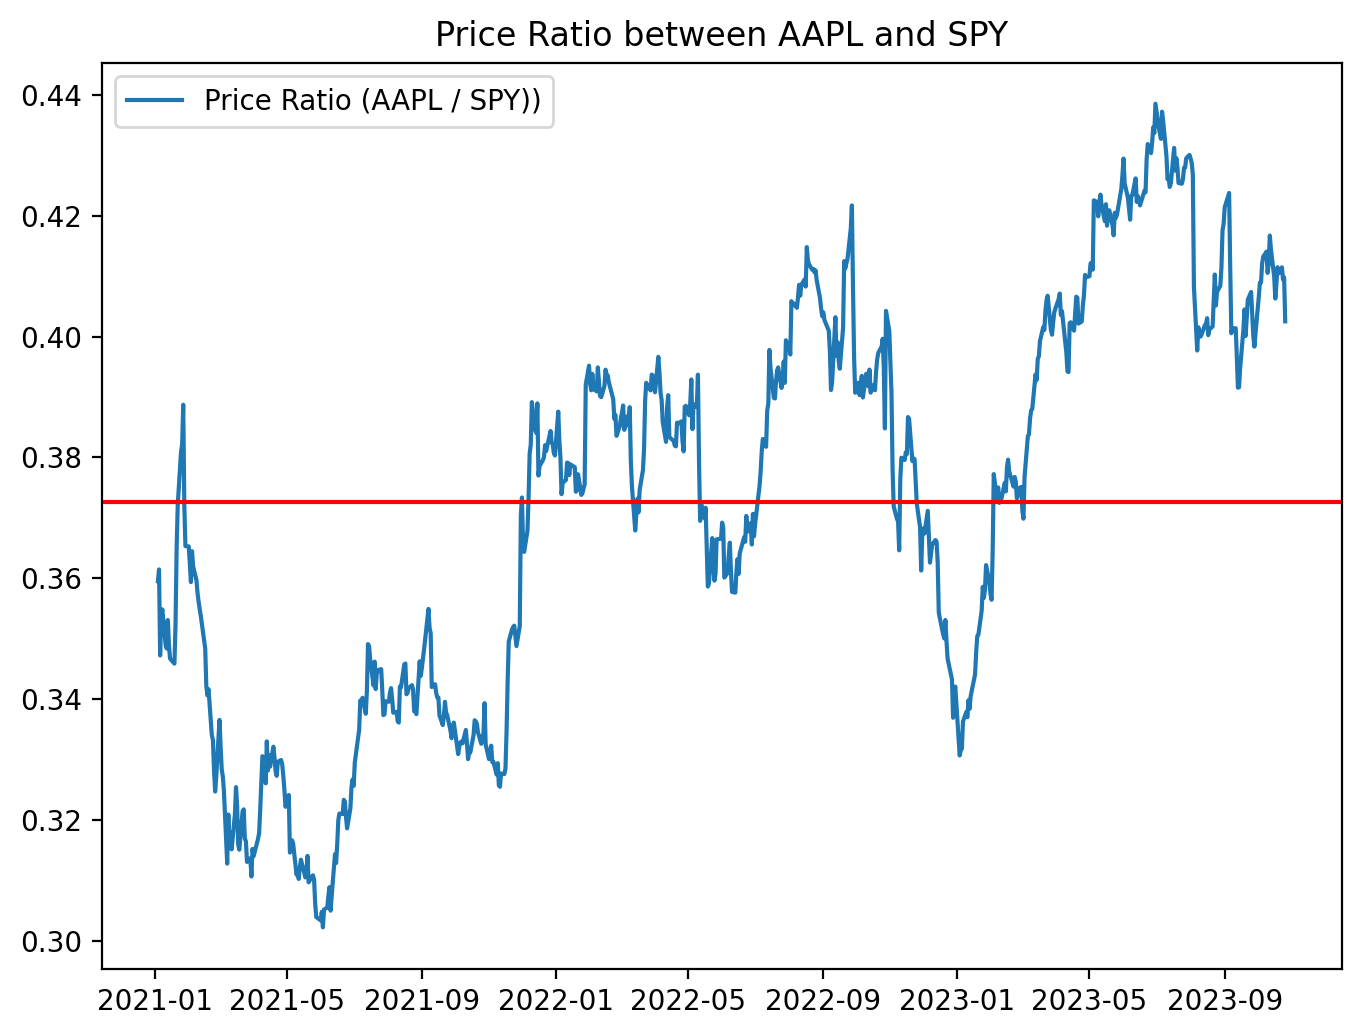

In [163]:
# Also, we can take a look at the price ratios between the two time series.
figure(figsize=(8, 6), dpi=200)
ratio = Stock_A / Stock_B
plt.plot(ratio, label = f'Price Ratio ({ticker_A} / {ticker_B}))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between AAPL and SPY")

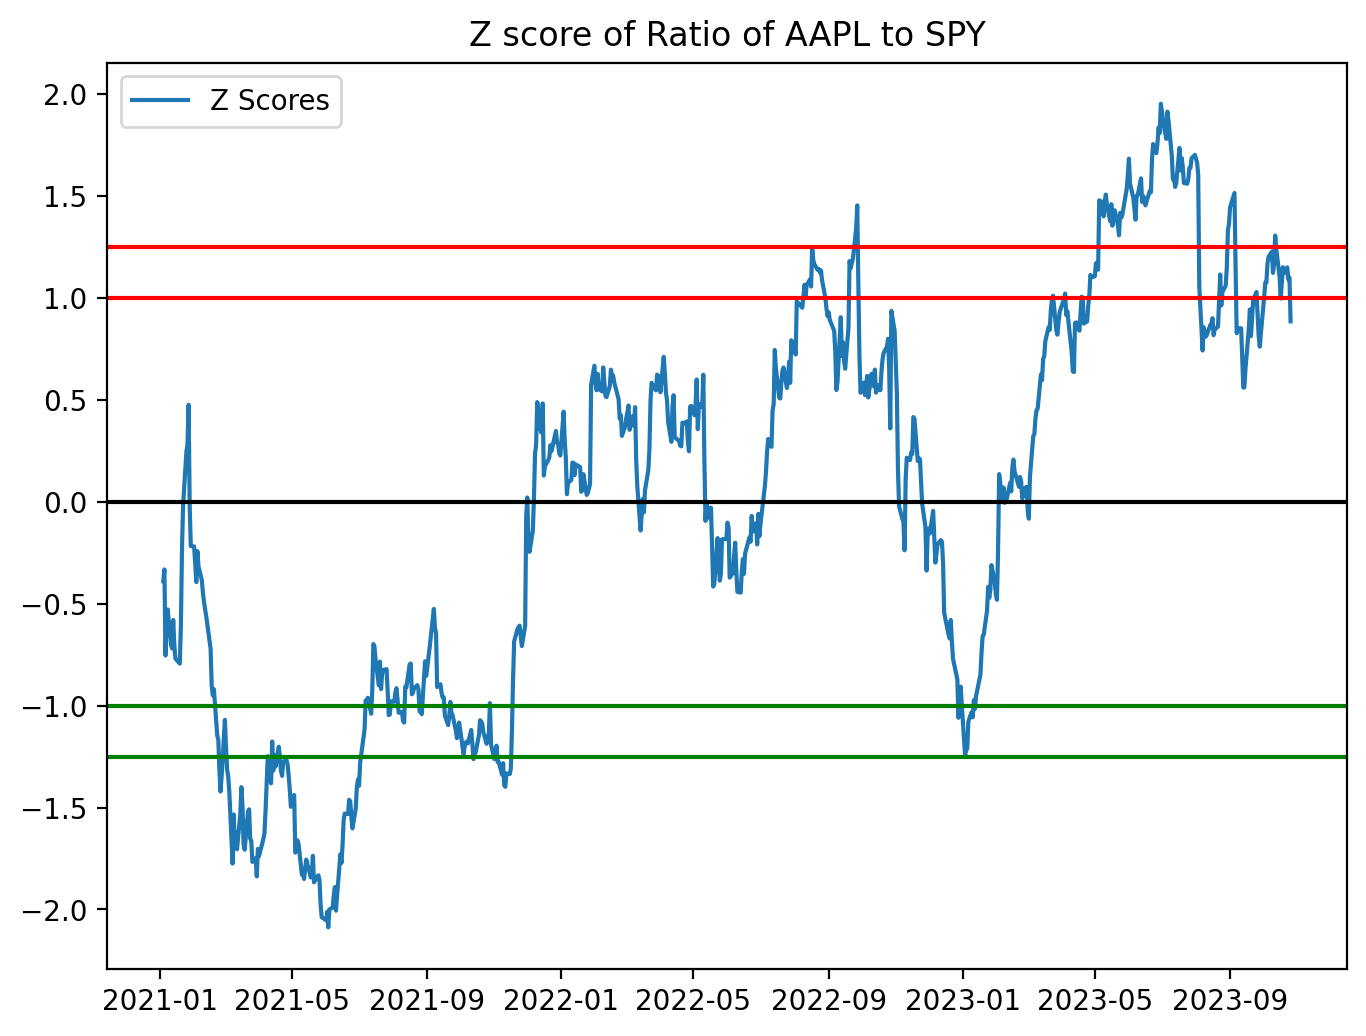

In [164]:
figure(figsize=(8, 6), dpi=200)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title(f'Z score of Ratio of {ticker_A} to {ticker_B}')
plt.show()
# For the most part, the range that exists outside of these 'bands' must come converge back to the mean. Thus, you can 
# determine when you can go long or short the pair (BRK_B to MSFT).

# Excercise
## Pairs trading

1. Pick 2 correlated tickers from the list and plot them in ticker_A and ticker_B place holders, see if they are mean reverting
2. Calculate their price ratio and Z-Score
3. Create 2 new columns: Calculate the Returns_A and Returns_B 
3. Create 2 new columns: Signal_A and Signal_B to open,close or short positions in their respective ticker
4. Create an algorithm which:
    - If Z_Score < -1.25 -> Long A, Short B     i.e. Signal_A = 1 and Signal_B = -1
    - If Z_Score = 0 -> Close Positions     i.e. Signal_A = 0 and Signal_B = 0
    - If Z_Score > 1.25 -> Short A, Long B      i.e. Signal_A = -1 and Signal_B = 1
5. Lag both signal columns by 1 day
6. Create a Total Returns Column where: Tot_Returns = Signal_A * Returns_A + Signal_B * Returns_B 
7. Compute and Plot Cumulative Returns!



Remember to keep position open until crossing the Z=0 line not when Z_score falls slightly below 1.25 or rises slightly than -1.25

Formulas: 
- Price Ratio = Price Stock A / Price Stock B
- Z-Score = (Price Ratio - Price Ratio Mean) / Price Ratio Standard Deviation

Good Luck!